## "Detection of anomalous reviews from Amazon using supervised outlier techniques"

Do you buy anything without reading other customers' reviews? Probably not and I surely wouldn't! Especially when you consider the inconvenience to return products and the potential of it getting lost in shipping. It's no surprise that review fraud has diminished the whole experience. You only need some bad reviews to evade the customers to look for other products. Amazon makes it easy to view other similar products, so why would a customer buy the product with a bad review? This can be very damaging for a business. This has been seen as a developing problem. In this notebook we try to address this important problem utilizing natural language processing (NLP) and various machine learning methodologies and techniques to achieve a breakthrough in this sector. Many e-commerce sites, such as Amazon, have their systems in place, including Verified Purchase, which labels review language as accurate when items are purchased directly from the website. This notebook proposes to use Amazon's verified purchases label to train a supervised classification model. We use Amazon’s labeled dataset for training two models. The trained baseline model had an AUC score of 84% and the proposed model had a AUC score of 99%. Both models indicate that there are distinctions between false and actual reviews. Out of the two, the feature engineering improved the model performance by 29%.
 


The dataset is from kaggle and can be found [here:](https://www.kaggle.com/akudnaver/amazon-reviews-dataset).

In [1]:
# Importing the Dependencies and Loading the Data

import sys  
sys.path.append('../src/visualization')
sys.path.append('../src/processing')

In [2]:
sys.path

['/Users/elizabethdinevski/asset-dev/AnomaliesInAmazonReviews/notebooks',
 '/Users/elizabethdinevski/asset-dev/AnomaliesInAmazonReviews/env/lib/python39.zip',
 '/Users/elizabethdinevski/asset-dev/AnomaliesInAmazonReviews/env/lib/python3.9',
 '/Users/elizabethdinevski/asset-dev/AnomaliesInAmazonReviews/env/lib/python3.9/lib-dynload',
 '',
 '/Users/elizabethdinevski/asset-dev/AnomaliesInAmazonReviews/env/lib/python3.9/site-packages',
 '../src/visualization',
 '../src/processing']

In [3]:
%matplotlib inline

import re
import string

import joblib
import pandas as pd
import numpy as np

import seaborn as sns

#SciKit-Learn
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#Tensorflow / Keras
import tensorflow as tf
    
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Plotting
import matplotlib.pyplot as plt
from association import associations_fun
from TextFeatureEngineering import *
from DataCleansing import *

#Test
from collections import Counter
from nltk.stem.porter import PorterStemmer


import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.simplefilter("ignore")


In [4]:
# Loading the dataset
df = pd.read_csv('../data/external/amazon_reviews_2019.csv',encoding="latin1") #due to special charas should be encoded as latin 1

In [5]:
n_reviews, n_attributes = df.shape
print('Total Reviews: ',n_reviews)
print('Total Attributes: ',n_attributes)

Total Reviews:  2501
Total Attributes:  32


# Exploratory Data Analysis

## Handling Missing Data

Missing data can skew anything for data scientists. After all, any analysis is only as good as the data. A data scientist doesn’t want to produce biased estimates that lead to invalid results. When dealing with missing data, data scientists must understand why the data is missing. Some consideration:

* Data Missing at Random? (MAR)
* Missing Completely at Random? (MCAR)
* Missing Not at Random? (NMAR)

There are many approaches for dealing with missing data:

* Deleting data
*  Imputation

When data is missing, it may make sense to delete data, as mentioned above. However, that may not be the most effective option. For example, if too much information is discarded, it may not be possible to complete a reliable analysis.

Instead of deletion, data scientists have multiple solutions to impute the value of missing data. Depending why the data are missing, imputation methods can deliver reasonably reliable results.

For simplicity, we opted to delete all the features that contain missing values.

The code below shows all the features with missing values in percentage.


In [6]:
missing_values = df.isna().mean().round(4) * 100

print('%s%%' % missing_values)

report_date                 0.00
online_store                0.00
upc                         0.00
retailer_product_code       0.00
brand                       0.00
category                    0.00
sub_category                0.00
product_description         0.00
review_date                 0.00
review_rating               0.00
review_title                3.92
review_text                 0.00
is_competitor               0.00
manufacturer                0.00
market                      0.00
matched_keywords          100.00
time_of_publication       100.00
url                        33.87
review_type                 0.00
parent_review               0.00
manufacturers_response    100.00
dimension1                  0.00
dimension2                  0.00
dimension3                  7.64
dimension4                100.00
dimension5                100.00
dimension6                100.00
dimension7                  0.08
dimension8                  0.00
verified_purchase           0.00
helpful_re

In [7]:
df.drop(['matched_keywords', 'time_of_publication', 'url', 
         'manufacturers_response', 'dimension3', 'dimension4', 
         'dimension5', 'dimension6', 'dimension7'], inplace=True, axis=1)

In [8]:
df.head()

,report_date,online_store,upc,retailer_product_code,brand,category,sub_category,product_description,review_date,review_rating,...,manufacturer,market,review_type,parent_review,dimension1,dimension2,dimension8,verified_purchase,helpful_review_count,review_hash_id
0,1/2/2019,FRESHAMAZON,8.718110e+12,B0142CI6FC,Dove Men+Care,Personal Care,Deos,Dove Men+Care Extra Fresh Anti-perspirant Deod...,1/1/2019,5,...,Unilever Global,UK,Organic,Child,Deos,Male Anti-Perspirant Deodorant,Core of the Core,True,0,3f129b02-ea76-0323-bd59-235d97a4f83f
1,1/3/2019,FRESHAMAZON,5.000180e+12,B014DFNNRY,Marmite,Foods,Savoury,Marmite Spread Yeast Extract 500g,1/2/2019,5,...,Unilever Global,UK,Organic,Child,Savoury,COTC Yeast Extract,Core of the Core,True,0,d7f3b9aa-e8b3-626d-683b-374e201c8315
2,1/3/2019,FRESHAMAZON,5.000180e+12,B014DFNNRY,Marmite,Foods,Savoury,Marmite Spread Yeast Extract 500g,1/2/2019,4,...,Unilever Global,UK,Organic,Child,Savoury,COTC Yeast Extract,Core of the Core,True,0,e58a523d-0155-a366-f107-7ac6817ac3b7
3,1/3/2019,FRESHAMAZON,8.712570e+12,B014DFKELC,Knorr,Foods,Savoury,Knorr Beef Stock Pot 8 x 28g,1/2/2019,5,...,Unilever Global,UK,Organic,Parent,Savoury,Beef Stock/Pots/Cubes/Extract/Liquid/Concentrated,Core of the Core,True,0,aaa9bb87-4f99-bb89-65cb-3b400ebb45c0
4,1/3/2019,FRESHAMAZON,8.717160e+12,B014G37I7E,Cif,Homecare,HHC,Cif Citrus Bathroom Mousse 500ml,1/2/2019,5,...,Unilever Global,UK,Organic,Parent,HHC,Bathroom Mousse,Core of the Core,False,0,48c71b34-d7fe-5e90-51dd-239e153fb0ae


The 'review_title' feature has 3.92% missing values. We will attempt to fill the missing values.

In [9]:
df['review_title'].fillna('', inplace=True)

In [10]:
missing_values = df.review_title.isna().mean().round(4) * 100

print('%s%%' % missing_values)

0.0%


## Feature Selection

IDs don't directly add value for the anomaly detection model, so we will drop the ID features below!

In [11]:
df['review_hash_id'].head()

0    3f129b02-ea76-0323-bd59-235d97a4f83f
1    d7f3b9aa-e8b3-626d-683b-374e201c8315
2    e58a523d-0155-a366-f107-7ac6817ac3b7
3    aaa9bb87-4f99-bb89-65cb-3b400ebb45c0
4    48c71b34-d7fe-5e90-51dd-239e153fb0ae
Name: review_hash_id, dtype: object

In [12]:
df['retailer_product_code'].head()

0    B0142CI6FC
1    B014DFNNRY
2    B014DFNNRY
3    B014DFKELC
4    B014G37I7E
Name: retailer_product_code, dtype: object

In [13]:
df['upc'].head()

0    8.718110e+12
1    5.000180e+12
2    5.000180e+12
3    8.712570e+12
4    8.717160e+12
Name: upc, dtype: float64

In [14]:
df.drop(['review_hash_id', 'retailer_product_code', 'upc'], inplace=True, axis=1)

A correlation matrix is a common tool used to compare the coefficients of correlation between different features (or attributes) in a dataset. It allows us to visualize how much (or how little) correlation exists between different variables. This is an important step in pre-processing machine learning pipelines. Since the correlation matrix allows us to identify variables that have high degrees of correlation, they allow us to reduce the amount of features we may have in a dataset. This is often referred to as dimensionality reduction and can be used to improve the runtime and effectiveness of our models.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2501 entries, 0 to 2500
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   report_date           2501 non-null   object
 1   online_store          2501 non-null   object
 2   brand                 2501 non-null   object
 3   category              2501 non-null   object
 4   sub_category          2501 non-null   object
 5   product_description   2501 non-null   object
 6   review_date           2501 non-null   object
 7   review_rating         2501 non-null   int64 
 8   review_title          2501 non-null   object
 9   review_text           2501 non-null   object
 10  is_competitor         2501 non-null   int64 
 11  manufacturer          2501 non-null   object
 12  market                2501 non-null   object
 13  review_type           2501 non-null   object
 14  parent_review         2501 non-null   object
 15  dimension1            2501 non-null   

Convert the object features to category data type. This is to visualize the categorical correlation!

In [16]:
df['online_store'] = df['online_store'].astype('category')
df['brand'] = df['brand'].astype('category')
df['category'] = df['category'].astype('category')
df['sub_category'] = df['sub_category'].astype('category')
df['product_description'] = df['product_description'].astype('category')
df['review_title'] = df['review_title'].astype('category')
df['review_text'] = df['review_text'].astype('category')
df['manufacturer'] = df['manufacturer'].astype('category')
df['market'] = df['market'].astype('category')
df['review_type'] = df['review_type'].astype('category')
df['parent_review'] = df['parent_review'].astype('category')
df['dimension1'] = df['dimension1'].astype('category')
df['dimension2'] = df['dimension2'].astype('category')
df['dimension8'] = df['dimension8'].astype('category')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2501 entries, 0 to 2500
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   report_date           2501 non-null   object  
 1   online_store          2501 non-null   category
 2   brand                 2501 non-null   category
 3   category              2501 non-null   category
 4   sub_category          2501 non-null   category
 5   product_description   2501 non-null   category
 6   review_date           2501 non-null   object  
 7   review_rating         2501 non-null   int64   
 8   review_title          2501 non-null   category
 9   review_text           2501 non-null   category
 10  is_competitor         2501 non-null   int64   
 11  manufacturer          2501 non-null   category
 12  market                2501 non-null   category
 13  review_type           2501 non-null   category
 14  parent_review         2501 non-null   category
 15  dime

In [18]:
objList = df.select_dtypes(include = "category").columns
print (objList)

Index(['online_store', 'brand', 'category', 'sub_category',
       'product_description', 'review_title', 'review_text', 'manufacturer',
       'market', 'review_type', 'parent_review', 'dimension1', 'dimension2',
       'dimension8'],
      dtype='object')


In [19]:
categ = ['category', 'sub_category', 'dimension1', 'dimension2', 'dimension8']

In [20]:
df[categ].head()

,category,sub_category,dimension1,dimension2,dimension8
0,Personal Care,Deos,Deos,Male Anti-Perspirant Deodorant,Core of the Core
1,Foods,Savoury,Savoury,COTC Yeast Extract,Core of the Core
2,Foods,Savoury,Savoury,COTC Yeast Extract,Core of the Core
3,Foods,Savoury,Savoury,Beef Stock/Pots/Cubes/Extract/Liquid/Concentrated,Core of the Core
4,Homecare,HHC,HHC,Bathroom Mousse,Core of the Core


In [21]:
np.unique(df['dimension8'])

array(['Core of the Core'], dtype=object)

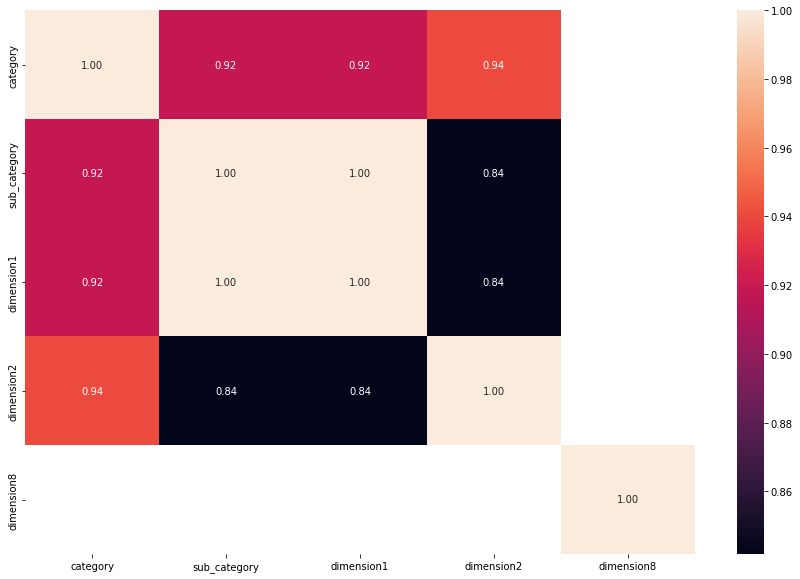

In [22]:
associations_fun(df[categ], nominal_columns=categ, figsize=(15, 10))

We can see from the above correlation matrix that the 'dimension1' feature is a copy of the 'sub_category' feature. Moreover, the 'dimension2' feature is highly correlated with 'dimension1', 'category' and 'sub_category' features. The feature 'dimension8' contains the same value. Also, 'sub_category' is highly correlated with 'category'. In this case we are going to remove these features sub_category, dimension1, dimension2, and dimension8.  

In [23]:
df.drop(['sub_category', 'dimension1', 'dimension2', 'dimension8'], inplace=True, axis=1)

The 'is_competitor' has all values 0, We will also remove this feature.

In [24]:
np.unique(df['is_competitor'])

array([0])

In [25]:
df.drop(['is_competitor'], inplace=True, axis=1)

The 'market' has all values 'UK', We will also remove this feature.

In [26]:
np.unique(df['market'])

array(['UK'], dtype=object)

In [27]:
df.drop(['market'], inplace=True, axis=1)

The 'manufacturer' has all values 'Unilever Global', We will also remove this feature.

In [28]:
np.unique(df['manufacturer'])

array(['Unilever Global'], dtype=object)

In [29]:
df.drop(['manufacturer'], inplace=True, axis=1)

## Handling Temporal Features and Perform Feature Engineering


We start by converting the string to datetime.

In [30]:
df['report_date'] = df.apply(lambda x: datetime.strptime(x['report_date'], '%m/%d/%Y'), axis=1)
df.report_date = pd.to_datetime(df.report_date)

In [31]:
df['review_date'] = df.apply(lambda x: datetime.strptime(x['review_date'], '%m/%d/%Y'), axis=1)
df.report_date = pd.to_datetime(df.report_date)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2501 entries, 0 to 2500
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   report_date           2501 non-null   datetime64[ns]
 1   online_store          2501 non-null   category      
 2   brand                 2501 non-null   category      
 3   category              2501 non-null   category      
 4   product_description   2501 non-null   category      
 5   review_date           2501 non-null   datetime64[ns]
 6   review_rating         2501 non-null   int64         
 7   review_title          2501 non-null   category      
 8   review_text           2501 non-null   category      
 9   review_type           2501 non-null   category      
 10  parent_review         2501 non-null   category      
 11  verified_purchase     2501 non-null   bool          
 12  helpful_review_count  2501 non-null   int64         
dtypes: bool(1), catego

Get the review time between the reported and actually reviewed.

In [33]:
delta = df['report_date'] - df['review_date']
df['review_delt'] = delta.dt.components.days

In [34]:
df.drop(['report_date', 'review_date'], inplace=True, axis=1)

From the below table we can see from the event on the third row that the 'review_title' feature gives more context to the 'review_text'. We decided to merge the two columns to be processed together.

In [35]:
df.head()

,online_store,brand,category,product_description,review_rating,review_title,review_text,review_type,parent_review,verified_purchase,helpful_review_count,review_delt
0,FRESHAMAZON,Dove Men+Care,Personal Care,Dove Men+Care Extra Fresh Anti-perspirant Deod...,5,Dove Mens + Deodorant,"As you get older, you know what you like and w...",Organic,Child,True,0,1
1,FRESHAMAZON,Marmite,Foods,Marmite Spread Yeast Extract 500g,5,Great for a marmite lover!,Three gigantic marmite jars that will last pro...,Organic,Child,True,0,1
2,FRESHAMAZON,Marmite,Foods,Marmite Spread Yeast Extract 500g,4,Vitamin B12.,Excellent,Organic,Child,True,0,1
3,FRESHAMAZON,Knorr,Foods,Knorr Beef Stock Pot 8 x 28g,5,A Very Handy Flavour Top - Up to Keep In The C...,A great flavour top - up for slow cooking.,Organic,Parent,True,0,1
4,FRESHAMAZON,Cif,Homecare,Cif Citrus Bathroom Mousse 500ml,5,Very handy,Does what is says it does,Organic,Parent,False,0,1


From the figure below it is not unexpected that personal care like skin and hair have a lot of fraudulent reviews. It is expected given all the available products on the market.

Text(0.5, 1.0, 'Count of Product category')

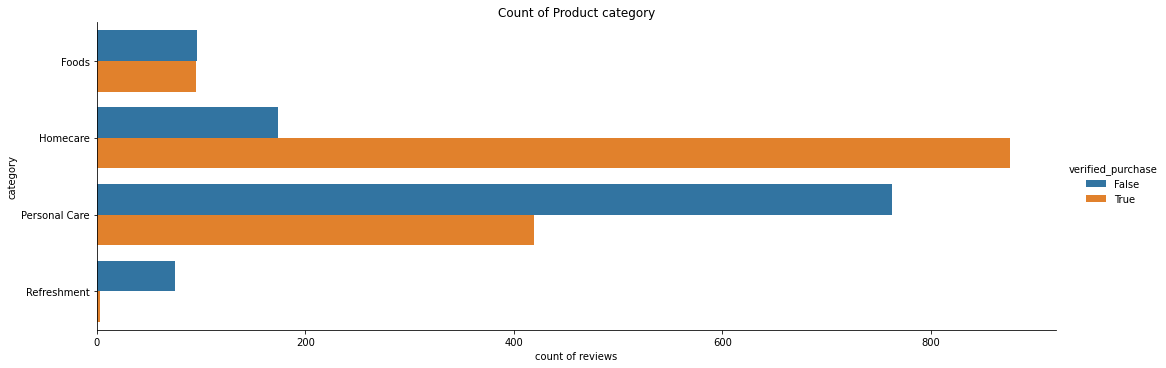

In [36]:
sns.catplot(y ='category',kind="count", hue = "verified_purchase", data=df,  height=5, aspect=3)
plt.ylabel("category")
plt.xlabel("count of reviews")
plt.title("Count of Product category")

In [37]:
df['title_review_comments'] = df.apply(lambda x: ' '.join([x['review_title'], x['review_text']]), axis=1)

In [38]:
df.head()

,online_store,brand,category,product_description,review_rating,review_title,review_text,review_type,parent_review,verified_purchase,helpful_review_count,review_delt,title_review_comments
0,FRESHAMAZON,Dove Men+Care,Personal Care,Dove Men+Care Extra Fresh Anti-perspirant Deod...,5,Dove Mens + Deodorant,"As you get older, you know what you like and w...",Organic,Child,True,0,1,"Dove Mens + Deodorant As you get older, you k..."
1,FRESHAMAZON,Marmite,Foods,Marmite Spread Yeast Extract 500g,5,Great for a marmite lover!,Three gigantic marmite jars that will last pro...,Organic,Child,True,0,1,Great for a marmite lover! Three gigantic marm...
2,FRESHAMAZON,Marmite,Foods,Marmite Spread Yeast Extract 500g,4,Vitamin B12.,Excellent,Organic,Child,True,0,1,Vitamin B12. Excellent
3,FRESHAMAZON,Knorr,Foods,Knorr Beef Stock Pot 8 x 28g,5,A Very Handy Flavour Top - Up to Keep In The C...,A great flavour top - up for slow cooking.,Organic,Parent,True,0,1,A Very Handy Flavour Top - Up to Keep In The C...
4,FRESHAMAZON,Cif,Homecare,Cif Citrus Bathroom Mousse 500ml,5,Very handy,Does what is says it does,Organic,Parent,False,0,1,Very handy Does what is says it does


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2501 entries, 0 to 2500
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   online_store           2501 non-null   category
 1   brand                  2501 non-null   category
 2   category               2501 non-null   category
 3   product_description    2501 non-null   category
 4   review_rating          2501 non-null   int64   
 5   review_title           2501 non-null   category
 6   review_text            2501 non-null   category
 7   review_type            2501 non-null   category
 8   parent_review          2501 non-null   category
 9   verified_purchase      2501 non-null   bool    
 10  helpful_review_count   2501 non-null   int64   
 11  review_delt            2501 non-null   int64   
 12  title_review_comments  2501 non-null   object  
dtypes: bool(1), category(8), int64(3), object(1)
memory usage: 238.8+ KB


## Converting Nominal Variables

Most machine learning algorithms can't handle categorical data. We use label encoders to handle nominal variables. 

In [40]:
catFeature = ['online_store', 'brand', 'category', 'review_type', 'parent_review']
# Encode Categorical Columns
le = LabelEncoder()
df[catFeature] = df[catFeature].apply(le.fit_transform)

In [41]:
df[catFeature].head()

,online_store,brand,category,review_type,parent_review
0,4,12,2,0,0
1,4,19,0,0,0
2,4,19,0,0,0
3,4,15,0,0,1
4,4,6,1,0,1


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2501 entries, 0 to 2500
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   online_store           2501 non-null   int64   
 1   brand                  2501 non-null   int64   
 2   category               2501 non-null   int64   
 3   product_description    2501 non-null   category
 4   review_rating          2501 non-null   int64   
 5   review_title           2501 non-null   category
 6   review_text            2501 non-null   category
 7   review_type            2501 non-null   int64   
 8   parent_review          2501 non-null   int64   
 9   verified_purchase      2501 non-null   bool    
 10  helpful_review_count   2501 non-null   int64   
 11  review_delt            2501 non-null   int64   
 12  title_review_comments  2501 non-null   object  
dtypes: bool(1), category(3), int64(8), object(1)
memory usage: 322.1+ KB


In [43]:
df.head()

,online_store,brand,category,product_description,review_rating,review_title,review_text,review_type,parent_review,verified_purchase,helpful_review_count,review_delt,title_review_comments
0,4,12,2,Dove Men+Care Extra Fresh Anti-perspirant Deod...,5,Dove Mens + Deodorant,"As you get older, you know what you like and w...",0,0,True,0,1,"Dove Mens + Deodorant As you get older, you k..."
1,4,19,0,Marmite Spread Yeast Extract 500g,5,Great for a marmite lover!,Three gigantic marmite jars that will last pro...,0,0,True,0,1,Great for a marmite lover! Three gigantic marm...
2,4,19,0,Marmite Spread Yeast Extract 500g,4,Vitamin B12.,Excellent,0,0,True,0,1,Vitamin B12. Excellent
3,4,15,0,Knorr Beef Stock Pot 8 x 28g,5,A Very Handy Flavour Top - Up to Keep In The C...,A great flavour top - up for slow cooking.,0,1,True,0,1,A Very Handy Flavour Top - Up to Keep In The C...
4,4,6,1,Cif Citrus Bathroom Mousse 500ml,5,Very handy,Does what is says it does,0,1,False,0,1,Very handy Does what is says it does


The code below maps the boolean values to numerical values used as the target variable. We can also notice that there are slightly higher verified purchases than not, however the two classes are pretty balanced.

In [44]:
df['verified_purchase'].replace({True: 0, False: 1}, inplace=True)

In [45]:
df.head()

,online_store,brand,category,product_description,review_rating,review_title,review_text,review_type,parent_review,verified_purchase,helpful_review_count,review_delt,title_review_comments
0,4,12,2,Dove Men+Care Extra Fresh Anti-perspirant Deod...,5,Dove Mens + Deodorant,"As you get older, you know what you like and w...",0,0,0,0,1,"Dove Mens + Deodorant As you get older, you k..."
1,4,19,0,Marmite Spread Yeast Extract 500g,5,Great for a marmite lover!,Three gigantic marmite jars that will last pro...,0,0,0,0,1,Great for a marmite lover! Three gigantic marm...
2,4,19,0,Marmite Spread Yeast Extract 500g,4,Vitamin B12.,Excellent,0,0,0,0,1,Vitamin B12. Excellent
3,4,15,0,Knorr Beef Stock Pot 8 x 28g,5,A Very Handy Flavour Top - Up to Keep In The C...,A great flavour top - up for slow cooking.,0,1,0,0,1,A Very Handy Flavour Top - Up to Keep In The C...
4,4,6,1,Cif Citrus Bathroom Mousse 500ml,5,Very handy,Does what is says it does,0,1,1,0,1,Very handy Does what is says it does


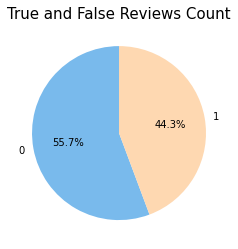

In [46]:
#PIE CHART ON VERFIED PURCHASES - check one
colors = ['#79BAEC','#FED8B1']
plt.figure(figsize=(4,4))
label = df['verified_purchase'].value_counts()
plt.pie(label.values,colors = colors, labels=label.index, autopct= '%1.1f%%', startangle=90)
plt.title('True and False Reviews Count', fontsize=15)
plt.show()

We save the file and in the next section we will use NLP to process both 'product_description' and 'title_review_comments' features.   

In [47]:
# Saving updated dataframe.

df.to_csv('../data/processed/updated_data_proposed.csv')

# Utilizing Natural Language Processing

In [48]:
#due to special charas should be encoded as latin 1
df = pd.read_csv('../data/processed/updated_data_proposed.csv',encoding='latin1') 
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [49]:
df.head()

,online_store,brand,category,product_description,review_rating,review_title,review_text,review_type,parent_review,verified_purchase,helpful_review_count,review_delt,title_review_comments
0,4,12,2,Dove Men+Care Extra Fresh Anti-perspirant Deod...,5,Dove MenÂs + Deodorant,"As you get older, you know what you like and w...",0,0,0,0,1,"Dove MenÂs + Deodorant As you get older, you ..."
1,4,19,0,Marmite Spread Yeast Extract 500g,5,Great for a marmite lover!,Three gigantic marmite jars that will last pro...,0,0,0,0,1,Great for a marmite lover! Three gigantic marm...
2,4,19,0,Marmite Spread Yeast Extract 500g,4,Vitamin B12.,Excellent,0,0,0,0,1,Vitamin B12. Excellent
3,4,15,0,Knorr Beef Stock Pot 8 x 28g,5,A Very Handy Flavour Top - Up to Keep In The C...,A great flavour top - up for slow cooking.,0,1,0,0,1,A Very Handy Flavour Top - Up to Keep In The C...
4,4,6,1,Cif Citrus Bathroom Mousse 500ml,5,Very handy,Does what is says it does,0,1,1,0,1,Very handy Does what is says it does


Check total duplicate occurrences.

In [50]:
dup = df.duplicated().sum()
print('Number of duplicates in dataset: ', dup)

Number of duplicates in dataset:  0


Before we clean the text features, we will attempt to extract some insight from the text. Below is a set of functions that look at the counts of various aspects, such as: word, sentens, character counts. We will leave 'product_description' feature out because 'product_description' feature is not customer reviews.

In [51]:
def make_feature(df, feature_name_in):
    tmp_df = df.copy()
    tmp_df['char_count'] = tmp_df[feature_name_in].apply(lambda x:count_chars(x))
    tmp_df['word_count'] = tmp_df[feature_name_in].apply(lambda x:count_words(x))
    tmp_df['sent_count'] = tmp_df[feature_name_in].apply(lambda x:count_sent(x))
    tmp_df['capital_char_count'] = tmp_df[feature_name_in].apply(lambda x:count_capital_chars(x))
    tmp_df['capital_word_count'] = tmp_df[feature_name_in].apply(lambda x:count_capital_words(x))
    tmp_df['quoted_word_count'] = tmp_df[feature_name_in].apply(lambda x:count_words_in_quotes(x))
    tmp_df['stopword_count'] = tmp_df[feature_name_in].apply(lambda x:count_stopwords(x))
    tmp_df['unique_word_count'] = tmp_df[feature_name_in].apply(lambda x:count_unique_words(x))
    tmp_df['htag_count'] = tmp_df[feature_name_in].apply(lambda x:count_htags(x))
    tmp_df['mention_count'] = tmp_df[feature_name_in].apply(lambda x:count_mentions(x))
    tmp_df['punct_count'] = tmp_df[feature_name_in].apply(lambda x:count_punctuations(x))
    tmp_df['avg_wordlength']= tmp_df['char_count']/tmp_df['word_count']
    tmp_df['avg_sentlength']= tmp_df['word_count']/tmp_df['sent_count']
    tmp_df['unique_vs_words']= tmp_df['unique_word_count']/tmp_df['word_count']
    tmp_df['stopwords_vs_words']= tmp_df['stopword_count']/tmp_df['word_count']
    
    return tmp_df

In [52]:
with_review_only = make_feature(df, 'review_text')
with_review_title_only = make_feature(df, 'title_review_comments')

In [53]:
with_review_title_only.head()

,online_store,brand,category,product_description,review_rating,review_title,review_text,review_type,parent_review,verified_purchase,...,quoted_word_count,stopword_count,unique_word_count,htag_count,mention_count,punct_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words
0,4,12,2,Dove Men+Care Extra Fresh Anti-perspirant Deod...,5,Dove MenÂs + Deodorant,"As you get older, you know what you like and w...",0,0,0,...,0,17,35,0,0,"{'! count': 1, '"" count': 0, '# count': 0, '$ ...",5.255814,10.75,0.813953,0.395349
1,4,19,0,Marmite Spread Yeast Extract 500g,5,Great for a marmite lover!,Three gigantic marmite jars that will last pro...,0,0,0,...,0,11,33,0,0,"{'! count': 2, '"" count': 0, '# count': 0, '$ ...",5.771429,7.00,0.942857,0.314286
2,4,19,0,Marmite Spread Yeast Extract 500g,4,Vitamin B12.,Excellent,0,0,0,...,0,0,3,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",7.333333,1.50,1.000000,0.000000
3,4,15,0,Knorr Beef Stock Pot 8 x 28g,5,A Very Handy Flavour Top - Up to Keep In The C...,A great flavour top - up for slow cooking.,0,1,0,...,0,3,19,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",4.619048,10.50,0.904762,0.142857
4,4,6,1,Cif Citrus Bathroom Mousse 500ml,5,Very handy,Does what is says it does,0,1,1,...,0,4,8,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",4.500000,8.00,1.000000,0.500000


The 'punct_count' feature is represented as a dictionary. The below code attempts to expand to columns.

In [54]:
def expand_punct_column(_df):
    df_punct= pd.DataFrame(list(_df.punct_count))
    
    # Merging the pnctuation DataFrame with main DataFrame
    _df=pd.merge(_df, df_punct, left_index=True, right_index=True)
    
    # We can drop "punct_count" column.
    _df.drop(columns=['punct_count'], inplace=True)
    
    return _df

In [55]:
with_review_only = expand_punct_column(with_review_only)
with_review_title_only = expand_punct_column(with_review_title_only)

In [56]:
with_review_title_only.head()

,online_store,brand,category,product_description,review_rating,review_title,review_text,review_type,parent_review,verified_purchase,...,[ count,\ count,] count,^ count,_ count,` count,{ count,| count,} count,~ count
0,4,12,2,Dove Men+Care Extra Fresh Anti-perspirant Deod...,5,Dove MenÂs + Deodorant,"As you get older, you know what you like and w...",0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,19,0,Marmite Spread Yeast Extract 500g,5,Great for a marmite lover!,Three gigantic marmite jars that will last pro...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,19,0,Marmite Spread Yeast Extract 500g,4,Vitamin B12.,Excellent,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,15,0,Knorr Beef Stock Pot 8 x 28g,5,A Very Handy Flavour Top - Up to Keep In The C...,A great flavour top - up for slow cooking.,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,4,6,1,Cif Citrus Bathroom Mousse 500ml,5,Very handy,Does what is says it does,0,1,1,...,0,0,0,0,0,0,0,0,0,0


Next we apply a fleet of functions to clean text features and remove common and rare words. We remove:

* Repeated characters
* Separate digit
* Slang
* Stem words
* Single characters
* Punctuations
* Extra space
* Replace digits with characters
* Emoticons
* URL
* Alphanumerics
* Stop words

In [57]:
def clean_feature(_df, feature_name):
    _df[feature_name] = _df[feature_name].apply(lambda i: appos_look_up(i))
    _df[feature_name] = _df[feature_name].apply(lambda i: remove_repeated_characters(i))
    _df[feature_name] = _df[feature_name].apply(lambda i: separate_digit_text(i))
    _df[feature_name] = _df[feature_name].apply(lambda i: slang_look_up(i))
    _df[feature_name] = _df[feature_name].apply(lambda i: stem_text(i))
    _df[feature_name] = _df[feature_name].apply(lambda i: remove_single_char_word(i))
    _df[feature_name] = _df[feature_name].apply(lambda i: remove_punctuations(i))
    _df[feature_name] = _df[feature_name].apply(lambda i: remove_extra_space(i))
    _df[feature_name] = _df[feature_name].apply(lambda i: replace_digits_with_char(i))
    _df[feature_name] = _df[feature_name].apply(lambda i: emoticons_look_up(i)[0])
    _df[feature_name] = _df[feature_name].apply(lambda i: remove_url(i))
    _df[feature_name] = _df[feature_name].apply(lambda i: remove_alphanumerics(i))
    _df[feature_name] = _df[feature_name].apply(lambda i: remove_stop_words(i))
    
    _df[feature_name] = _df[feature_name].apply(lambda i: ''.join(TextBlob(i).correct()))
    
    # removing common and rare words
    common = pd.Series(' '.join(_df[feature_name]).split()).value_counts()[:3]
    common = list(common.index)
    _df[feature_name] = _df[feature_name].apply(lambda i: " ".join(i for i in i.split() if i not in common))
    
    rare = pd.Series(' '.join(_df[feature_name]).split()).value_counts()[-3:]
    rare = list(rare.index)
    _df[feature_name] = _df[feature_name].apply(lambda i: " ".join(i for i in i.split() if i not in rare))
    
    
    return _df

In [58]:
with_review_only = clean_feature(with_review_only, 'review_text')
with_review_title_only = clean_feature(with_review_title_only, 'title_review_comments')

In [59]:
with_review_only['review_text'].head()

0    get older know like suitable like give fresh w...
1    three giant admit jar last probably whole life...
2                                                expel
3                          great flavour top slow cook
4                                                  say
Name: review_text, dtype: object

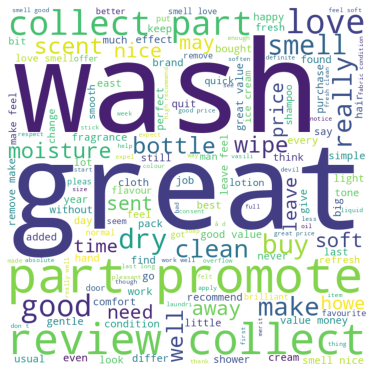

In [60]:
#WordCloud

words = '' 
for i in with_review_only["review_text"]: 
    tokens = i.split()   
    words += " ".join(tokens)+" "

    
word_cloud = WordCloud(width=700, height=700, background_color='white', min_font_size=10).generate(words) 
plt.figure(figsize = (5, 5)) 
plt.imshow(word_cloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [61]:
with_review_title_only['title_review_comments'].head()

0    men door get older know like suitable like gi...
1    great admit lover three giant admit jar last p...
2                                    vitamin bed expel
3    hand flavour top keep cupboard great flavour t...
4                                             hand say
Name: title_review_comments, dtype: object

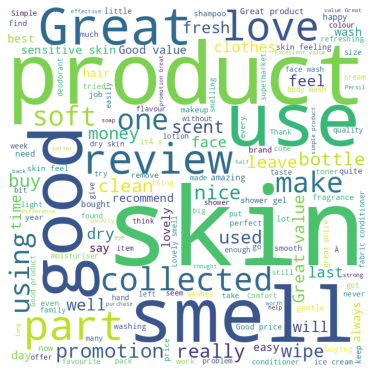

In [62]:
#WordCloud

words = '' 
for i in with_review_only["title_review_comments"]: 
    tokens = i.split()   
    words += " ".join(tokens)+" "

    
word_cloud = WordCloud(width=700, height=700, background_color='white', min_font_size=10).generate(words) 
plt.figure(figsize = (5, 5)) 
plt.imshow(word_cloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [63]:
# Saving cleaned dataframe.

with_review_only.to_csv('../data/processed/cleaned_review_only_proposed.csv')
with_review_title_only.to_csv('../data/processed/cleaned_review_and_title_only_proposed.csv')

# Training ML models

In [64]:
# Due to special charas should be encoded as latin 1

with_review_only = pd.read_csv("../data/processed/cleaned_review_only_proposed.csv",encoding="latin1")
with_review_only.drop(['Unnamed: 0'], axis=1, inplace=True)

with_review_title_only = pd.read_csv("../data/processed/cleaned_review_and_title_only_proposed.csv",
                                     encoding="latin1")
with_review_title_only.drop(['Unnamed: 0'], axis=1, inplace=True)

Remove null values from the reviews 

In [65]:
n_reviews, n_attributes = with_review_only.shape
print('Total reviews before removing null values: ',n_reviews)
print('Total attributes: ',n_attributes)

Total reviews before removing null values:  2501
Total attributes:  59


Drop all the null rows.

In [66]:
with_review_only = with_review_only.dropna(how='any',axis=0) 

In [67]:
n_reviews, n_attributes = with_review_only.shape
print('Total reviews after removing null values: ',n_reviews)
print('Total attributes: ',n_attributes)

Total reviews after removing null values:  2386
Total attributes:  59


Remove null values from the reviews with title  

In [68]:
n_reviews, n_attributes = with_review_title_only.shape
print('Total reviews with title before removing null values: ',n_reviews)
print('Total attributes: ',n_attributes)

Total reviews with title before removing null values:  2501
Total attributes:  59


In [69]:
with_review_title_only = with_review_title_only.dropna(how='any',axis=0) 

In [70]:
n_reviews, n_attributes = with_review_title_only.shape
print('Total reviews with title after removing null values: ',n_reviews)
print('Total attributes: ',n_attributes)

Total reviews with title after removing null values:  2397
Total attributes:  59


## Train model with only the reviews

In [71]:
# Assign the text variables and the target variable

# Input variables
X_review = with_review_only['review_text'] 
X_product = with_review_only['product_description']

# The target variable
y = with_review_only['verified_purchase']

Text features are considered unstructured data. Tokenization of text documents can be indirectly used for representing documents. We often need to use algorithms like term frequency–inverse document frequency (TF-IDF) to account for token occurrences (meaning we break the sentence into words or tokens) in a document and turn an unstructured text into a numerical vector that is suitable for machine learning. There are many other techniques that can be used to convert text to numerical sequences. We will use tensorflow’s library to perform both the [Tokenization](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) and to convert to numerical vectors, known as embeddings.

In [72]:
#Define the Tokeniser
tokeniser1 = Tokenizer(num_words=10000, lower=True)
tokeniser2 = Tokenizer(num_words=10000, lower=True)

#Create the corpus by finding the most common 
tokeniser1.fit_on_texts(X_review)
tokeniser2.fit_on_texts(X_product)

In [73]:
#Tokenise our columns
review_tokens = tokeniser1.texts_to_sequences(list(X_review))
product_tokens = tokeniser2.texts_to_sequences(list(X_product))

In [74]:
#Pad these sequences to make them the same length
review_tokens = pad_sequences(review_tokens, truncating='post', padding='post', maxlen=50)
product_tokens = pad_sequences(product_tokens, truncating='post', padding='post', maxlen=50)

Each row from below matrix is a numerical vector that represent one sentence from each customer review.

In [75]:
review_tokens

array([[ 18, 828, 178, ...,   0,   0,   0],
       [288, 682, 211, ...,   0,   0,   0],
       [102,   0,   0, ...,   0,   0,   0],
       ...,
       [466,  23,   3, ...,   0,   0,   0],
       [ 21,   2, 794, ...,   0,   0,   0],
       [ 14, 106, 423, ...,   0,   0,   0]], dtype=int32)

In [76]:
product_tokens

array([[ 19,  60,  29, ...,   0,   0,   0],
       [153, 162, 139, ...,   0,   0,   0],
       [153, 162, 139, ...,   0,   0,   0],
       ...,
       [136, 207, 175, ...,   0,   0,   0],
       [187, 188, 189, ...,   0,   0,   0],
       [187, 188, 189, ...,   0,   0,   0]], dtype=int32)

Remove all the text features that we just converted to numerical vectores.

In [77]:
with_review_only.drop(columns=['title_review_comments', 
                               'product_description', 
                               'verified_purchase',
                               'review_title',
                               'review_text'], inplace=True)

In [78]:
with_review_only.head()

,online_store,brand,category,review_rating,review_type,parent_review,helpful_review_count,review_delt,char_count,word_count,...,[ count,\ count,] count,^ count,_ count,` count,{ count,| count,} count,~ count
0,4,12,2,5,0,0,0,1,202,39,...,0,0,0,0,0,0,0,0,0,0
1,4,19,0,5,0,0,0,1,175,30,...,0,0,0,0,0,0,0,0,0,0
2,4,19,0,4,0,0,0,1,9,1,...,0,0,0,0,0,0,0,0,0,0
3,4,15,0,5,0,1,0,1,42,9,...,0,0,0,0,0,0,0,0,0,0
4,4,6,1,5,0,1,0,1,25,6,...,0,0,0,0,0,0,0,0,0,0


Finally before we train the classification model we have to combine the customer reviews and product description with the rest of the features that we created earlier.

In [79]:
with_review_only.reset_index(inplace=True, drop=True)
review_tokens_df = pd.DataFrame(review_tokens)
product_tokens_df = pd.DataFrame(product_tokens)

In [80]:
df_new = pd.concat([with_review_only, 
                    review_tokens_df, 
                    product_tokens_df], join='inner', ignore_index=False, axis=1)

Next, we split the dataset into training and testing where we use 20% for the testing and 80% for training.

In [81]:
X_train, X_test, y_train, y_test = train_test_split(df_new, y, test_size=0.2, random_state=1)

We build a random forest classification model with default parameters.

In [82]:
rfc = RandomForestClassifier(random_state=1)

In [83]:
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [86]:
#whether the reviews written has been verified or not by Amazon's system

#Define the indexing for each possible label in a dictionary
class_to_index = {"notVerified-(1)":1, "verified-(0)":0}

#Creates a reverse dictionary
index_to_class = dict((v,k) for k, v in class_to_index.items())

#Creates lambda functions, applying the appropriate dictionary
names_to_ids = lambda n: np.array([class_to_index.get(x) for x in n])
ids_to_names = lambda n: np.array([index_to_class.get(x) for x in n])

In [87]:
#Generate predictions
y_pred = np.argmax(rfc.predict_proba(X_test), axis=1)

#Assign labels to predictions and test data
y_pred_labels = ids_to_names(y_pred)
y_test_labels = ids_to_names(y_test)

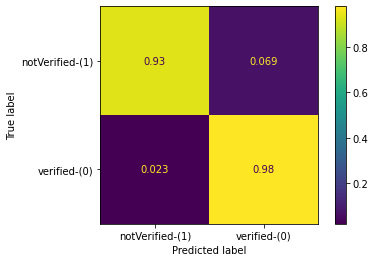

In [88]:
y_unique = list(set(y_test_labels))
cm = confusion_matrix(y_test_labels, y_pred_labels, labels = y_unique, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_unique)
disp.plot()

## Train model with reviews and title


We repeat the same steps for modeling with both reviews and the title features.

In [89]:
# Assign the text variables and the target variable

# Input variables
X_review = with_review_title_only['title_review_comments'] 
X_product = with_review_title_only['product_description']

# The target variable
y = with_review_title_only['verified_purchase']

In [90]:
#Define the Tokeniser
tokeniser1 = Tokenizer(num_words=10000, lower=True)
tokeniser2 = Tokenizer(num_words=10000, lower=True)

#Create the corpus by finding the most common 
tokeniser1.fit_on_texts(X_review)
tokeniser2.fit_on_texts(X_product)

In [91]:
#Tokenise our columns
review_title_tokens = tokeniser1.texts_to_sequences(list(X_review))
product_tokens = tokeniser2.texts_to_sequences(list(X_product))

In [92]:
#Pad these sequences to make them the same length
review_title_tokens = pad_sequences(review_title_tokens, truncating='post', padding='post', maxlen=50)
product_tokens = pad_sequences(product_tokens, truncating='post', padding='post', maxlen=50)

In [93]:
with_review_title_only.drop(columns=['title_review_comments', 
                                     'product_description', 
                                     'verified_purchase',
                                     'review_title',
                                     'review_text'], inplace=True)

In [94]:
with_review_title_only.head()

,online_store,brand,category,review_rating,review_type,parent_review,helpful_review_count,review_delt,char_count,word_count,...,[ count,\ count,] count,^ count,_ count,` count,{ count,| count,} count,~ count
0,4,12,2,5,0,0,0,1,226,43,...,0,0,0,0,0,0,0,0,0,0
1,4,19,0,5,0,0,0,1,202,35,...,0,0,0,0,0,0,0,0,0,0
2,4,19,0,4,0,0,0,1,22,3,...,0,0,0,0,0,0,0,0,0,0
3,4,15,0,5,0,1,0,1,97,21,...,0,0,0,0,0,0,0,0,0,0
4,4,6,1,5,0,1,0,1,36,8,...,0,0,0,0,0,0,0,0,0,0


In [95]:
with_review_title_only.reset_index(inplace=True, drop=True)
review_title_tokens_df = pd.DataFrame(review_title_tokens)
product_tokens_df = pd.DataFrame(product_tokens)

In [96]:
df_new = pd.concat([with_review_title_only, 
                    review_title_tokens_df, 
                    product_tokens_df], join='inner', ignore_index=False, axis=1)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(df_new, y, test_size=0.2, random_state=1)

In [98]:
rfc = RandomForestClassifier(random_state=1)

In [99]:
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [100]:
#whether the reviews written has been verified or not by Amazon's system

#Define the indexing for each possible label in a dictionary
class_to_index = {"notVerified-(1)":1, "verified-(0)":0}

#Creates a reverse dictionary
index_to_class = dict((v,k) for k, v in class_to_index.items())

#Creates lambda functions, applying the appropriate dictionary
names_to_ids = lambda n: np.array([class_to_index.get(x) for x in n])
ids_to_names = lambda n: np.array([index_to_class.get(x) for x in n])

In [101]:
#Generate predictions
y_pred = np.argmax(rfc.predict_proba(X_test), axis=1)

#Assign labels to predictions and test data
y_pred_labels = ids_to_names(y_pred)
y_test_labels = ids_to_names(y_test)

The confusion matrix is a technique that summarizes the performance of a classification algorithm. The concept of a confusion matrix is that the model is confused when it makes predictions. The number of correct and incorrect predictions are summarized with count values and broken down by each class. This is the key to the confusion matrix.

Well, it is a performance measurement for machine learning classification problem where output can be two or more classes. It is a table with 4 different combinations of predicted and actual values.

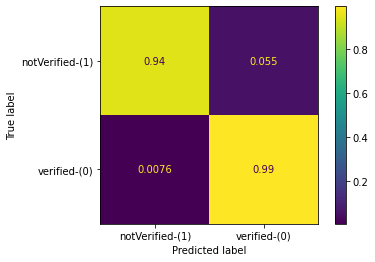

In [102]:
y_unique = list(set(y_test_labels))
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=y_unique, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_unique)
disp.plot()

Confusion matrices are extremely useful for measuring recall, precision, specificity, accuracy, and, most importantly, AUC-ROC curves
Let’s understand the above confusion matrix (more on this from [here](https://en.wikipedia.org/wiki/Confusion_matrix)).

* notVerified = positive (that is fraud because it was not verified)
* verified = negative (that is no fraud, because it is verified)



* True Positive (TP):
 * Green box in the top left hand quadrant with 94%
 * Interpretation: You predicted positive and it’s true.
 * You predicted that the review is not verified and it actually is not verified. 
 
* True Negative (TN):
 * Yellow box in the lower right hand quadrant with 99%
 * Interpretation: You predicted negative and it’s true.
 * You predicted that review is verified and the review is actually is. That is in yellow box with 99%.

* False Positive (FP): (Type 1 Error)
 * Purple box in the bottom left hand corner with 0.76%
 * Interpretation: You predicted positive and it’s false.
 * You predicted that a review is not verified, but it actually is.

* False Negative (FN): (Type 2 Error)
 * Purple box in the top right hand corner with 5.5%
 * Interpretation: You predicted negative and it’s false.
 * You predicted that the review is verified but it actually is not verified.

It is evident from the above results that combining the engineered features with customer reviews yields higher performance above 90% from both TP and TN and low type 1 FP and 2 FN errors, compared to just using customer reviews from baseline model that yields above 70%. That is a 29% improvement.

In [103]:
roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1])

0.987971846767981

# Save model

In [104]:
filename = '../models/finalized_model_proposed.sav'
joblib.dump(rfc, filename)

['../models/finalized_model_proposed.sav']

Load the saved model

In [105]:
model = joblib.load(filename)

In [106]:
input_data = np.array([[0.        ,  30.        ,   1.        ,   1.        ,
                        0.        ,   1.        ,   0.        ,  30.        ,
                        51.        ,   9.        ,   1.        ,   2.        ,
                        0.        ,   0.        ,   3.        ,   7.        ,
                        0.        ,   0.        ,   5.66666667,   9.        ,
                        0.77777778,   0.33333333,   0.        ,   0.        ,
                        0.        ,   0.        ,   0.        ,   0.        ,
                        0.        ,   0.        ,   0.        ,   0.        ,
                        0.        ,   0.        ,   0.        ,   0.        ,
                        0.        ,   0.        ,   0.        ,   0.        ,
                        0.        ,   0.        ,   0.        ,   0.        ,
                        0.        ,   0.        ,   0.        ,   0.        ,
                        0.        ,   0.        ,   0.        ,   0.        ,
                        0.        ,   0.        ,   5.        , 119.        ,
                        5.        , 119.        , 271.        , 215.        ,
                        0.        ,   0.        ,   0.        ,   0.        ,
                        0.        ,   0.        ,   0.        ,   0.        ,
                        0.        ,   0.        ,   0.        ,   0.        ,
                        0.        ,   0.        ,   0.        ,   0.        ,
                        0.        ,   0.        ,   0.        ,   0.        ,
                        0.        ,   0.        ,   0.        ,   0.        ,
                        0.        ,   0.        ,   0.        ,   0.        ,
                        0.        ,   0.        ,   0.        ,   0.        ,
                        0.        ,   0.        ,   0.        ,   0.        ,
                        0.        ,   0.        ,   0.        ,   0.        ,
                        0.        ,   0.        ,   0.        ,   0.        ,
                        77.        ,   2.        , 173.        ,  91.        ,
                        92.        ,  93.        ,  75.        ,  94.        ,
                        0.        ,   0.        ,   0.        ,   0.        ,
                        0.        ,   0.        ,   0.        ,   0.        ,
                        0.        ,   0.        ,   0.        ,   0.        ,
                        0.        ,   0.        ,   0.        ,   0.        ,
                        0.        ,   0.        ,   0.        ,   0.        ,
                        0.        ,   0.        ,   0.        ,   0.        ,
                        0.        ,   0.        ,   0.        ,   0.        ,
                        0.        ,   0.        ,   0.        ,   0.        ,
                        0.        ,   0.        ,   0.        ,   0.        ,
                        0.        ,   0.        ,   0.        ,   0.        ,
                        0.        ,   0.        ]])

In [108]:
print('Expected label should be: 0, and the predicted is: %s' % model.predict(input_data)[0])

Expected label should be: 0, and the predicted is: 0


# Summary

Now that we have a saved model. you can deploy it into your infrastructure. This model can help you to detect and remove frauds in customer reviews to help protect your business. However, the same process can be easily adopted to other text based fraud problems, like claims processing. If you find this information helpful and would like to learn more about ML models, feel free to [reach out to the phData ML team](https://www.phdata.io/contact-us/). We’re here to help!